Adapted for the Deep Learning Indaba graph neural network tutorial.
Based off the notebooks written by *Nikola Jovanović* and *Lisa Wang and Nikola Jovanović*.


## Instructions

**Outline**
- [Warmup] Graphs, networkx
- [Part 1] Implementing GCN 
- [Part 2] Implementing GAT (Not included in the tutorial yet)

In [1]:
%%capture
!pip install git+https://github.com/deepmind/jraph.git
!pip install flax
!pip install dm-haiku
!pip install networkx

In [2]:
# Imports
%matplotlib inline
import functools
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.tree_util as tree
import jraph
import flax
import haiku as hk
import optax
import pickle
import numpy as onp
import networkx as nx
from typing import Any, Callable, Dict, List, Optional, Tuple

## [Warmup] Graphs, networkx

### Recap of graph fundamentals

A **graph** is a pair $\mathcal{G} = (\mathcal{V}, \mathcal{E})$, where $\mathcal{V}$ is the set of $N$ **vertices** (nodes), and $\mathcal{E}$ is the set of graph **edges** (links), i.e., pairs $(u,v)$ representing a connection between two vertices $u,v \in \mathcal{V}$. We will here consider **undirected** graphs, meaning that $(u,v) \in \mathcal{E} \implies (v,u) \in \mathcal{E}$.

There are several ways to represent $\mathcal{E}$:
1. As a **list of edges**: a list of pairs $(u,v)$, where $(u,v)$ means that there is an edge going from node $u$ to node $v$.
2. As an **adjacency matrix**: a binary square matrix $A$ of size $|\mathcal{V}| \times |\mathcal{V}|$, where $A_{u,v}=1$ iff there is a connection between nodes $u$ and $v$.
3. As an **adjacency list**: An array of $|\mathcal{V}|$ unordered lists, where the $i$th list corresponds to the $i$th node, and contains all the nodes directly connected to node $i$.


Example: Below is a directed graph with four nodes and five edges.

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/toy_graph.png" width="400px">

The arrows on the edges indicate the direction of each edge, e.g. there is an edge going from node 0 to node 1. Between node 0 and node 3, there are two edges: one going from node 0 to node 3 and one from node 3 to node 0.

Node 0 has out-degree of 2, since it has two outgoing edges, and an in-degree of 2, since it has two incoming edges.

The list of edges is:
$$[(0, 1), (0, 3), (1, 2), (2, 0), (3, 0)]$$

As adjacency matrix:

$$\begin{array}{l|llll}
 source \setminus dest    & n_0 & n_1 & n_2 & n_3 \\ \hline
n_0 & 0    & 1    & 0    & 1    \\
n_1 & 0    & 0    & 1    & 0    \\
n_2 & 1    & 0    & 0    & 0    \\
n_3 & 1    & 0    & 0    & 0
\end{array}$$

As adjacency list:

$$[\{1, 3\}, \{2\}, \{0\}, \{0\}]$$



### NetworkX





NetworkX is a Python library focused on graphs and networks, offering a large number of useful methods, including visualization which we will use several times in this colab.

Let's create and draw a simple graph:

### ***Task 1: Graph definition***

The first task is to recreate the graph below using Networkx. Fill in you solution between `### BEGIN SOLUTION` and `### END SOLUTION`. Note that the position of the node in the graph you plot may differ from this image. What matters is that the same nodes are connected.**bold text**

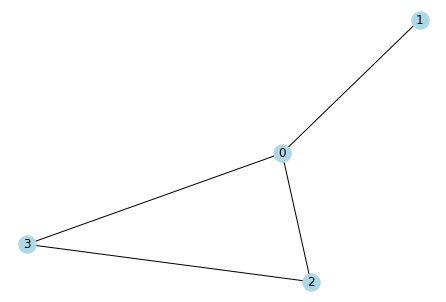

Graph G with 4 nodes and 4 edges
Adjacency list: [(0, 1), (0, 2), (0, 3), (2, 3)]
Adjacency matrix (symmetric):
[[0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]]
Degree of node 1: 1


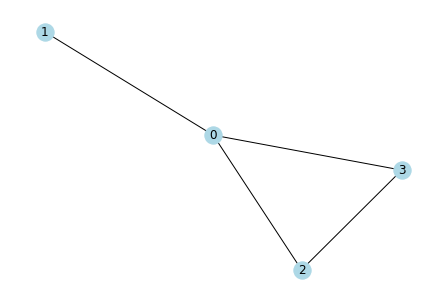

In [3]:
import networkx as nx 

# Create a simple graph
G = nx.Graph() # Use DiGraph for directed graphs

### BEGIN SOLUTION
G.add_nodes_from(range(4)) # Fill in the list of node labels as integers
G.add_edges_from([(0, 1), (0, 2), (0, 3), (2, 3)]) # Fill in the list of node pairs [(node_a, node_b)]
# Note that for a NetworkX (undirected) Graph, you do not need to provide both (node_a, node_b) and (node_b, node_a)
## END SOLUTION

# Print basic info
nb_nodes = G.number_of_nodes()
nb_edges = G.number_of_edges()
print(f'Graph G with {nb_nodes} nodes and {nb_edges} edges')
print(f'Adjacency list: {G.edges}')
print(f'Adjacency matrix (symmetric):')
A = nx.adjacency_matrix(G) # Returns a sparse matrix
print(A.todense())
print(f'Degree of node 1: {G.degree(1)}')

# Draw the graph
nx.draw(G, with_labels=True, node_color='lightblue')

## Graph Prediction Tasks
What are the kinds of problems we want to solve on graphs?


The tasks fall into roughly three categories:

1. **Node Classification**: E.g. what is the topic of a paper given a citation network of papers?
2. **Link Prediction / Edge Classification**: E.g. are two people in a social network friends?
3. **Graph Classification**: E.g. is this protein molecule (represented as a graph) likely going to be effective?

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_tasks.png" width="700px">

*The three main graph learning tasks. Image source: Petar Veličković.*

Which examples of graph prediction tasks come to your mind? Which task types do they correspond to?



## Intro to the jraph Library

In the following sections, we will learn how to represent graphs and build GNNs in Python. We will use
[jraph](https://github.com/deepmind/jraph), a lightweight library for working with GNNs in [JAX](https://github.com/google/jax).

### Representing a graph in jraph

In jraph, a graph is represented with a `GraphsTuple` object. In addition to defining the graph structure of nodes and edges, you can also store node features, edge features and global graph features in a `GraphsTuple`.

In the `GraphsTuple`, edges are represented in two aligned arrays of node indices: senders (source nodes) and receivers (destinaton nodes).
Each index corresponds to one edge, e.g. edge `i` goes from `senders[i]` to `receivers[i]`.

You can even store multiple graphs in one `GraphsTuple` object.

We will start with creating a simple directed graph with 4 nodes and 5 edges. We will also add toy features to the nodes, using `2*node_index` as the feature.

We will later use this toy graph in the GCN demo.



In [4]:
def build_toy_graph() -> jraph.GraphsTuple:
  """Define a four node graph, each node has a scalar as its feature."""

  # Nodes are defined implicitly by their features.
  # We will add four nodes, each with a feature, e.g.
  # node 0 has feature [0.],
  # node 1 has featre [2.] etc.
  # len(node_features) is the number of nodes.
  node_features = jnp.array([[0.], [2.], [4.], [6.]])

  # We will now specify 5 directed edges connecting the nodes we defined above.
  # We define this with `senders` (source node indices) and `receivers`
  # (destination node indices).
  # For example, to add an edge from node 0 to node 1, we append 0 to senders,
  # and 1 to receivers.
  # We can do the same for all 5 edges:
  # 0 -> 1
  # 1 -> 2
  # 2 -> 0
  # 3 -> 0
  # 0 -> 3
  senders = jnp.array([0, 1, 2, 3, 0])
  receivers = jnp.array([1, 2, 0, 0, 3])

  # You can optionally add edge attributes to the 5 edges.
  edges = jnp.array([[5.], [6.], [7.], [8.], [8.]])

  # We then save the number of nodes and the number of edges.
  # This information is used to make running GNNs over multiple graphs
  # in a GraphsTuple possible.
  n_node = jnp.array([4])
  n_edge = jnp.array([5])

  # Optionally you can add `global` information, such as a graph label.
  global_context = jnp.array([[1]]) # Same feature dims as nodes and edges.
  graph = jraph.GraphsTuple(
      nodes=node_features,
      edges=edges,
      senders=senders,
      receivers=receivers,
      n_node=n_node,
      n_edge=n_edge,
      globals=global_context
      )
  return graph

In [ ]:
graph = build_toy_graph()

#### Inspecting the GraphsTuple


In [6]:
# Number of nodes
# Note that `n_node` returns an array. The length of `n_node` corresponds to
# the number of graphs stored in one `GraphsTuple`.
# In this case, we only have one graph, so n_node has length 1.
graph.n_node

DeviceArray([4], dtype=int32)

In [7]:
# Number of edges
graph.n_edge

DeviceArray([5], dtype=int32)

In [8]:
# Node features
graph.nodes

DeviceArray([[0.],
             [2.],
             [4.],
             [6.]], dtype=float32)

In [9]:
# Edge features
graph.edges

DeviceArray([[5.],
             [6.],
             [7.],
             [8.],
             [8.]], dtype=float32)

In [10]:
# Edges
graph.senders

DeviceArray([0, 1, 2, 3, 0], dtype=int32)

In [11]:
graph.receivers

DeviceArray([1, 2, 0, 0, 3], dtype=int32)

In [12]:
# Graph-level features
graph.globals

DeviceArray([[1]], dtype=int32)

#### Visualizing the Graph
To visualize the graph structure of the graph we created above, we will use the [`networkx`](networkx.org) library because it already has functions for drawing graphs.

We first convert the `jraph.GraphsTuple` to a `networkx.DiGraph`.

In [13]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

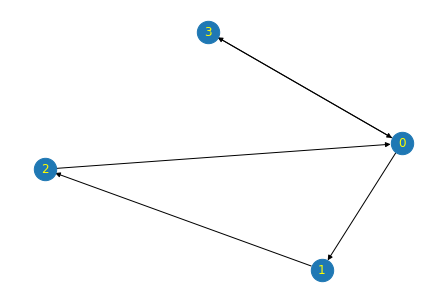

In [14]:
draw_jraph_graph_structure(graph)

## [Part 1] Implementing GNN models

The high-level perspective on the way GNNs are applied:



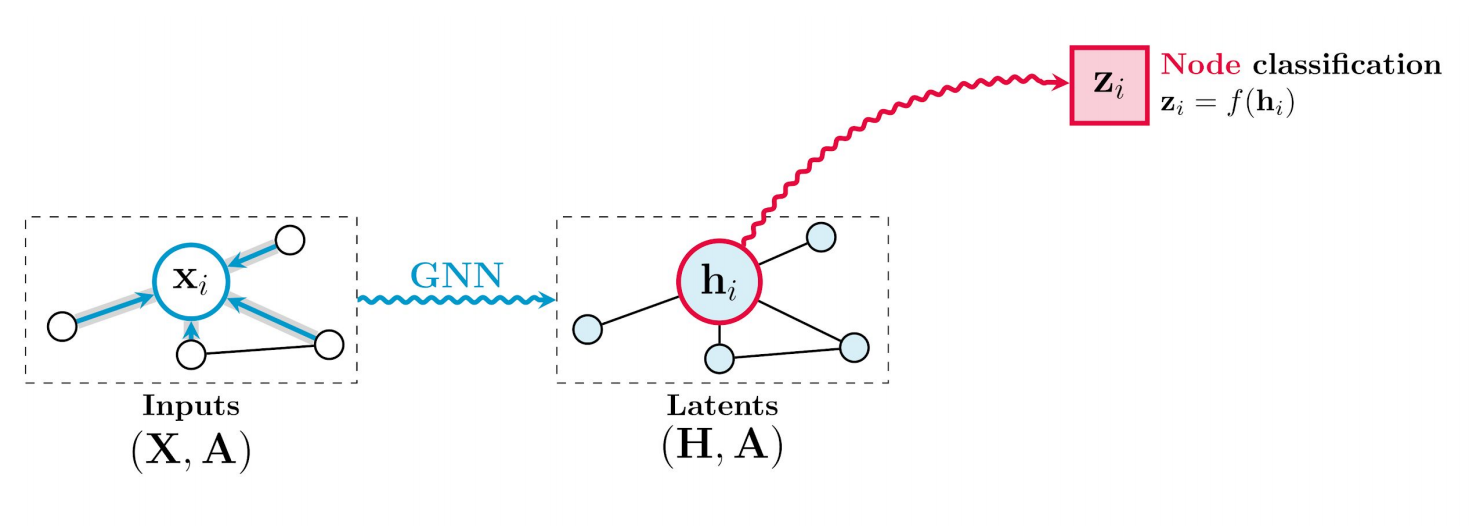

We start from a graph with adjacency matrix $A$ and node features $x_i$. Using a GNN, for each node we compute (based on its neighborhood) a latent feature vector $h_i$. With these we can attempt to solve various tasks, where for now we focus on **node classification**.

In node classification, we are most often given a single graph, where only a portion of nodes is labeled. Using these nodes as a signal for training, our goal is to successfully classify the remaining nodes. To this end, we look at previously computed node latent vectors in isolation, and learn a classifier $z_i = f(h_i)$.




#### ***Implement MLP baseline***

In [31]:
class MLP(hk.Module):
  def __init__(self, widening_factor:int, out_channels:int, number_classes: int = None):
    super().__init__()
    self.widening_factor = widening_factor
    self.out_channels = out_channels
    self.number_classes = number_classes

  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:

    mlp = hk.Sequential([hk.Linear(self.out_channels),
                         jax.nn.relu,
                         hk.Linear(self.out_channels * self.widening_factor),
                         jax.nn.relu,
                         hk.Linear(self.out_channels if not self.number_classes else self.number_classes)])

    return mlp(x)

# Use MLP block to define the update node function
update_node_fn = lambda x: MLP(widening_factor = 2, out_channels = 4)(x)

#### Check outputs of `update_node_fn` with MLP Block

In [32]:
graph = build_toy_graph()

In [33]:
update_node_module = hk.without_apply_rng(hk.transform(update_node_fn))
params = update_node_module.init(jax.random.PRNGKey(42), graph.nodes)
out = update_node_module.apply(params, graph.nodes)

As output, we expect the updated node features. We should see one array of dim 4 for each of the 4 nodes, which is the result of applying a single MLP block to the features of each node individually.

In [34]:
out

DeviceArray([[ 0.        ,  0.        ,  0.        ,  0.        ],
             [-2.4262953 , -0.15340242,  2.5150187 , -1.2854769 ],
             [-4.8525906 , -0.30680484,  5.0300374 , -2.5709538 ],
             [-7.278886  , -0.4602071 ,  7.5450563 , -3.8564317 ]],            dtype=float32)

#### GCN Definition

We can start working on our GCN model.

Given as inputs $A$, the $N \times N$ adjacency matrix, and $H$, the $N \times F$ feature matrix, where each node has an $F$-dimensional feature vector, the propagation rule of mean-pool is as follows:
$$ H' = \sigma(D^{-1}AHW^T) $$
Here, $W$ is a learnable weight matrix of shape $F' \times F$, $D$ is the diagonal matrices containing the degree of the nodes, $\sigma(\cdot)$ is a non-linear activation function (e.g. ReLU), and H' holds the output node features ($N \times F'$).

Focusing on node $i$, we get the following equation for its features (where $\mathcal{N}(i)$ is the set of its neighbors):
$$ h'_i = \sigma \left( \frac{1}{\mathcal{N}(i)}\sum_{j \in \mathcal{N}(i)}  Wh_j \right) $$

In other words, we simply average the transformed features of all neighbors. 

#### Add Symmetric Normalization

Note that the nodes may have different numbers of neighbors / degrees.
This could lead to instabilities during neural network training, e.g. exploding or vanishing gradients. To address that, normalization is a commonly used method. In this case, we will normalize by node degrees.

As a first attempt, we could count the number of incoming edges (including self-edge) and divide by that value.

More formally, let $A$ be the adjacency matrix defining the edges of the graph.

Then we define the degree matrix $D$ as a diagonal matrix with $D_{ii} = \sum_jA_{ij}$ (the degree of node $i$)


Now we can normalize $AH$ by dividing it by the node degrees:
$${D}^{-1}AH$$

To take both the in and out degrees into account, we can use symmetric normalization, which is also what Kipf and Welling proposed in their [paper](https://arxiv.org/abs/1609.02907):
$$D^{-\frac{1}{2}}AD^{-\frac{1}{2}}H$$

our update function would then be:

$$ H' = \sigma(D^{-\frac{1}{2}}AD^{-\frac{1}{2}}HW^T) $$





#### Add Self-Edges (Edges connecting a node to itself)
For each node, add an edge of the node onto itself. This way, nodes will include themselves in the aggregation step.

*Note*: if we don't add self-edges, a node would not depend on its own features which is clearly undesirable.

In [25]:
def add_self_edges_fn(receivers: jnp.ndarray, senders: jnp.ndarray,
                      total_num_nodes: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Adds self edges. Assumes self edges are not in the graph yet."""
  receivers = jnp.concatenate((receivers, jnp.arange(total_num_nodes)), axis=0)
  senders = jnp.concatenate((senders, jnp.arange(total_num_nodes)), axis=0)
  return receivers, senders

### GCN Layer implementation
Now we can write a more general and configurable version of the Graph Convolution layer, allowing the caller to specify:

*   **`update_node_fn`**: Function to use to update node features (e.g. the MLP block version we just implemented)
*   **`aggregate_nodes_fn`**: Aggregation function to use to aggregate messages from neighbourhood.
*  **`add_self_edges`**: Whether to add self edges for aggregation step.
* **`symmetric_normalization`**: Whether to add symmetric normalization.



In [35]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L506
def GraphConvolution(update_node_fn: Callable,
                    aggregate_nodes_fn: Callable = jax.ops.segment_sum,
                    add_self_edges: bool = False,
                    symmetric_normalization: bool = True) -> Callable:
    """Returns a method that applies a Graph Convolution layer.

    Graph Convolutional layer as in https://arxiv.org/abs/1609.02907,
    NOTE: This implementation does not add an activation after aggregation.
    If you are stacking layers, you may want to add an activation between
    each layer.
    Args:
        update_node_fn: function used to update the nodes. In the paper a single
        layer MLP is used.
        aggregate_nodes_fn: function used to aggregates the sender nodes.
        add_self_edges: whether to add self edges to nodes in the graph as in the
        paper definition of GCN. Defaults to False.
        symmetric_normalization: whether to use symmetric normalization. Defaults to
        True.

    Returns:
        A method that applies a Graph Convolution layer.
    """
    
    def _ApplyGCN(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
        """Applies a Graph Convolution layer."""
        nodes, _, receivers, senders, _, _, _ = graph

        # First pass nodes through the node updater.
        nodes = update_node_fn(nodes)
        # Equivalent to jnp.sum(n_node), but jittable
        total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
        if add_self_edges:
            # We add self edges to the senders and receivers so that each node
            # includes itself in aggregation.
            # In principle, a `GraphsTuple` should partition by n_edge, but in
            # this case it is not required since a GCN is agnostic to whether
            # the `GraphsTuple` is a batch of graphs or a single large graph.
            conv_receivers, conv_senders = add_self_edges_fn(receivers, senders,
                                                        total_num_nodes)
        else:
            conv_senders = senders
            conv_receivers = receivers

        # pylint: disable=g-long-lambda
        if symmetric_normalization:
            # Calculate the normalization values.
            count_edges = lambda x: jax.ops.segment_sum(
                jnp.ones_like(conv_senders), x, total_num_nodes)
            sender_degree = count_edges(conv_senders)
            receiver_degree = count_edges(conv_receivers)

            # Pre normalize by sqrt sender degree.
            # Avoid dividing by 0 by taking maximum of (degree, 1).
            nodes = tree.tree_map(
                lambda x: x * jax.lax.rsqrt(jnp.maximum(sender_degree, 1.0))[:, None],
                nodes,
            )
            # Aggregate the pre-normalized nodes.
            nodes = tree.tree_map(
                lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                            total_num_nodes), nodes)
            # Post normalize by sqrt receiver degree.
            # Avoid dividing by 0 by taking maximum of (degree, 1).
            nodes = tree.tree_map(
                lambda x:
                (x * jax.lax.rsqrt(jnp.maximum(receiver_degree, 1.0))[:, None]),
                nodes,
            )
        else:
            nodes = tree.tree_map(
                lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                            total_num_nodes), nodes)
        # pylint: enable=g-long-lambda
        return graph._replace(nodes=nodes)

    return _ApplyGCN

#### Test General GCN Layer

In [36]:
gcn_layer = GraphConvolution(
    update_node_fn = lambda n: MLP(widening_factor = 2, out_channels = 4)(n),
    aggregate_nodes_fn = jax.ops.segment_sum,
    add_self_edges = True,
    symmetric_normalization = True
)

In [37]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn_layer))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

DeviceArray([[-4.9526544 , -0.3131313 ,  5.13376   , -2.623969  ],
             [-1.2131476 , -0.0767012 ,  1.2575092 , -0.64273846],
             [-3.639443  , -0.23010363,  3.772528  , -1.9282154 ],
             [-3.6394427 , -0.23010354,  3.772528  , -1.9282157 ]],            dtype=float32)

### Build GCN Model with Multiple Layers
With a single GCN layer, a node's representation after the GCN layer is only
influenced by its direct neighbourhood. However, we may want to consider larger neighbourhoods, i.e. more than just 1 hop away. To achieve that, we can stack
multiple GCN layers, similar to how stacking CNN layers expands the input region.

We will define a network with three GCN layers:

In [39]:
def gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a graph neural network with 3 GCN layers.
    Args:
        graph: GraphsTuple the network processes.

    Returns:
        output graph with updated node values.
    """
    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
        add_self_edges=True)
    
    graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(4)(n)),
        add_self_edges=True)
    
    graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=hk.Linear(2))
    
    graph = gn(graph)
    
    return graph

In [40]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

DeviceArray([[-0.32386127,  0.10707338],
             [-0.23884146,  0.07896456],
             [-0.19206828,  0.06350064],
             [-0.23884146,  0.07896456]], dtype=float32)

### Node Classification with GCN on Karate Club Dataset

Time to try out our GCN on our first graph prediction task!


#### Zachary's Karate Club Dataset

[Zachary's karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) is a small dataset commonly used as an example for a social graph. It's great for demo purposes, as it's easy to visualize and quick to train a model on it.

A node represents a student or instructor in the club. An edge means that those two people have interacted outside of the class. There are two instructors in the club.

Each student is assigned to one of two instructors.

#### Optimizing the GCN on the Karate Club Node Classification Task

The task is to predict the assignment of students to instructors, given the social graph and only knowing the assignment of two nodes (the two instructors) a priori.

In other words, out of the 34 nodes, only two nodes are labeled, and we are trying to optimize the assignment of the other 32 nodes, by **maximizing the log-likelihood of the two known node assignments**.

We will compute the accuracy of our node assignments by comparing to the ground-truth assignments. **Note that the ground-truth for the 32 student nodes is not used in the loss function itself.**

Let's load the dataset:

In [41]:
"""Zachary's karate club example.
From https://github.com/deepmind/jraph/blob/master/jraph/examples/zacharys_karate_club.py.
Here we train a graph neural network to process Zachary's karate club.
https://en.wikipedia.org/wiki/Zachary%27s_karate_club
Zachary's karate club is used in the literature as an example of a social graph.
Here we use a graphnet to optimize the assignments of the students in the
karate club to two distinct karate instructors (Mr. Hi and John A).
"""

def get_zacharys_karate_club() -> jraph.GraphsTuple:
  """Returns GraphsTuple representing Zachary's karate club."""
  social_graph = [
      (1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
      (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
      (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
      (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
      (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
      (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
      (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
      (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
      (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
      (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
      (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
      (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
      (33, 31), (33, 32)]
  # Add reverse edges.
  social_graph += [(edge[1], edge[0]) for edge in social_graph]
  n_club_members = 34

  return jraph.GraphsTuple(
      n_node=jnp.asarray([n_club_members]),
      n_edge=jnp.asarray([len(social_graph)]),
      # One-hot encoding for nodes, i.e. argmax(nodes) = node index.
      nodes=jnp.eye(n_club_members),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([edge[0] for edge in social_graph]),
      receivers=jnp.asarray([edge[1] for edge in social_graph]))

def get_ground_truth_assignments_for_zacharys_karate_club() -> jnp.ndarray:
  """Returns ground truth assignments for Zachary's karate club."""
  return jnp.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
                    0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [42]:
graph = get_zacharys_karate_club()

In [43]:
print(f'Number of nodes: {graph.n_node[0]}')
print(f'Number of edges: {graph.n_edge[0]}')

Number of nodes: 34
Number of edges: 156


Visualize the karate club graph with circular node layout:

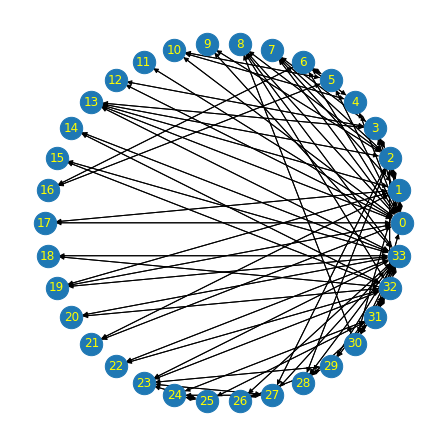

In [44]:
nx_graph = convert_jraph_to_networkx_graph(graph)
pos = nx.circular_layout(nx_graph)
plt.figure(figsize=(6, 6))
nx.draw(nx_graph, pos=pos, with_labels = True, node_size=500, font_color='yellow')

Define the GCN with the `GraphConvolution` layers we implemented:

In [46]:
def gcn_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a GCN for the karate club task.
    Args:
        graph: GraphsTuple the network processes.

    Returns:
        output graph with updated node values.
    """
    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
        add_self_edges=True)
    graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=hk.Linear(2)) # output dim is 2 because we have 2 output classes.
    graph = gn(graph)
    return graph

Training and evaluation code:

In [47]:
def optimize_club(network: hk.Transformed, params: hk.Params, \
                  graph_karate_club: jraph.GraphsTuple, labels: jnp.ndarray, \
                  num_steps: int) -> jnp.ndarray:
    """Solves the karate club problem by optimizing the assignments of students."""

    @jax.jit
    def predict(params: hk.Params) -> jnp.ndarray:
        decoded_graph = network.apply(params, graph_karate_club)
        return jnp.argmax(decoded_graph.nodes, axis=1)

    @jax.jit
    def prediction_loss(params: hk.Params) -> jnp.ndarray:
        decoded_graph = network.apply(params, graph_karate_club)
        # We interpret the decoded nodes as a pair of logits for each node.
        log_prob = jax.nn.log_softmax(decoded_graph.nodes)
        # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
        # and John A (Node 33).
        return -(log_prob[0, 0] + log_prob[33, 1])

    opt_init, opt_update = optax.adam(1e-2)
    opt_state = opt_init(params)

    @jax.jit
    def update(params: hk.Params, opt_state) -> Tuple[hk.Params, Any]:
        """Returns updated params and state."""
        g = jax.grad(prediction_loss)(params)
        updates, opt_state = opt_update(g, opt_state)
        return optax.apply_updates(params, updates), opt_state

    @jax.jit
    def accuracy(params: hk.Params) -> jnp.ndarray:
        decoded_graph = network.apply(params, graph_karate_club)
        return jnp.mean(jnp.argmax(decoded_graph.nodes, axis=1) == labels)

    for step in range(num_steps):
        print(f"step {step} accuracy {accuracy(params).item():.2f}")
        params, opt_state = update(params, opt_state)

    return predict(params)

Let's train the GCN! We expect this model reach an accuracy of about 0.91.

In [48]:
network = hk.without_apply_rng(hk.transform(gcn_definition))
graph_karate_club = get_zacharys_karate_club()
labels = get_ground_truth_assignments_for_zacharys_karate_club()
params = network.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)

step 0 accuracy 0.06
step 1 accuracy 0.15
step 2 accuracy 0.35
step 3 accuracy 0.50
step 4 accuracy 0.59
step 5 accuracy 0.68
step 6 accuracy 0.71
step 7 accuracy 0.74
step 8 accuracy 0.74
step 9 accuracy 0.76
step 10 accuracy 0.76
step 11 accuracy 0.91
step 12 accuracy 0.91
step 13 accuracy 0.91
step 14 accuracy 0.91



Try modifying the model parameters to see if you can improve the accuracy!

You can also modify the dataset itself, and see how that influences model training.

Node assignments predicted by the model at the end of training:

In [49]:
result

DeviceArray([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
             1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

Visualize ground truth and predicted node assignments:

What do you think of the results?

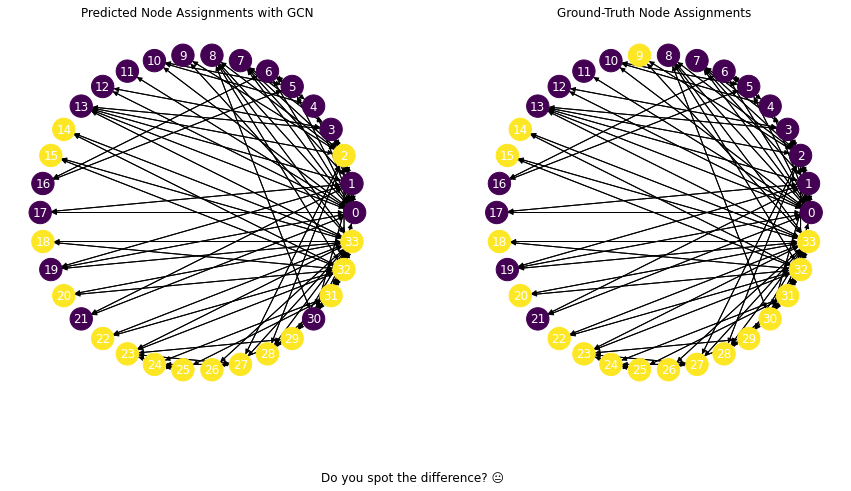

In [50]:
zacharys_karate_club = get_zacharys_karate_club()
nx_graph = convert_jraph_to_networkx_graph(zacharys_karate_club)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=result.tolist(),
    font_color='white')
ax1.title.set_text('Predicted Node Assignments with GCN')

gt_labels = get_ground_truth_assignments_for_zacharys_karate_club()
ax2 = fig.add_subplot(122)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=gt_labels.tolist(),
    font_color='white')
ax2.title.set_text('Ground-Truth Node Assignments')
fig.suptitle('Do you spot the difference? 😐', y=-0.01)

plt.show()